# Regression Analysis on Evictions, Poverty, and Race
In the "enhancing-statistical-rigor" notebook it became clear that the EL mislabeled the flag columns:
- imputed -- was accidentally labeled --> low-flag
- subbed -- was accidentally labeled --> imputed
- low-flag -- was accidentally labeled --> subbed.

So, I'll fix the labels and then compare regression analyses on:
- all the data
- filtered data (i.e. drop the data points that have been flagged as low)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf # cufflinks binds plotly to pandas dataframes in IPython notebook.
import plotly.graph_objs as go
from plotly import tools

In [2]:
sns.set(style = 'darkgrid')

## - Read in the County Level Data and correct the labels

In [3]:
counties_evicts_df = pd.read_csv('data/counties.csv')
counties_evicts_df.rename(columns = {'low-flag': 'imputed',
                                    'imputed': 'subbed',
                                    'subbed': 'low-flag'}, inplace = True)
counties_evicts_df.head()

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,imputed,subbed,low-flag
0,47001,2000,Anderson County,Tennessee,71330.0,13.14,27.49,450.0,35483.0,87500.0,...,1.14,0.07,8189.0,125.0,118.0,1.44,1.53,0,0,1
1,47003,2000,Bedford County,Tennessee,37586.0,13.14,26.46,488.0,36729.0,79000.0,...,0.77,0.05,3679.0,104.0,98.0,2.66,2.83,0,0,0
2,47005,2000,Benton County,Tennessee,16537.0,15.63,19.47,367.0,28679.0,67000.0,...,0.62,0.03,1336.0,17.0,17.0,1.27,1.27,0,0,0
3,47007,2000,Bledsoe County,Tennessee,12367.0,18.07,18.24,343.0,28982.0,67200.0,...,1.03,0.02,808.0,0.0,0.0,0.00,0.00,0,0,0
4,47009,2000,Blount County,Tennessee,105823.0,9.73,24.11,450.0,37862.0,103900.0,...,0.88,0.05,10286.0,210.0,201.0,1.95,2.04,0,0,1


Confirm my 'low-flag' column corroborates the criteria stated in pg. 40 of the methodology report
- *i.e. that at least 25% of the counties between 2009 - 2016 are flagged as low*
    - that's from January 1st 2009 - January 1st 2016

In [41]:
cty_09_15_index = [year in range(2009, 2016) for year in counties_evicts_df.year]
print('LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:') 
print("---------------------------------")
print('Years in range(2009, 2016)=', list(range(2009, 2016)))
print("")
print('Fraction of TN counties labeled as low:', counties_evicts_df[cty_09_15_index]['low-flag'].sum()/len(counties_evicts_df[cty_09_15_index]))
      

LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:
---------------------------------
Years in range(2009, 2016)= [2009, 2010, 2011, 2012, 2013, 2014, 2015]

Fraction of TN counties labeled as low: 0.24661654135338346


## - Pre-process the data for visualization and regression analysis
- pivot the counties for time series analysis

In [54]:
pivoted_counties = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'poverty-rate')
pivoted_counties.head()

name,Anderson County,Bedford County,Benton County,Bledsoe County,Blount County,Bradley County,Campbell County,Cannon County,Carroll County,Carter County,...,Unicoi County,Union County,Van Buren County,Warren County,Washington County,Wayne County,Weakley County,White County,Williamson County,Wilson County
year,,,,,,,,,,,,,,,,,,,,,
2000,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2001,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2002,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2003,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2004,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66


In [55]:
layout = go.Layout(
    autosize = True,
    #rangeslider = True,
    #width = 1600, 
    height = 800)

pivoted_counties.iplot(filename='pivoted-tn-county-poverty-timeseries', sharing = 'public',
                       #layout = layout,
                       width = 1, dash = 'line', mode = 'lines',
                      title = 'TN County Poverty Rate, 2000 - 2016', yTitle = 'Poverty %', xTitle = 'Year'
                      #rangeslider = True, 
                       )

## Plot the eviction rate time series for all counties

In [124]:
pvt_cnty_evic_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= ['eviction-rate', 'low-flag'])
pvt_cnty_evic_rates.head()


eviction-rate                                              \
name Anderson County Bedford County Benton County Bledsoe County   
year                                                               
2000            1.44           2.66          1.27           0.00   
2001            2.02           2.89          2.21           0.00   
2002            2.16           2.76          0.58           0.12   
2003            1.97           3.63          1.50           0.93   
2004            1.56           2.16          0.84           0.23   

                                                                 \
name Blount County Bradley County Campbell County Cannon County   
year                                                              
2000          1.95            NaN            1.75          0.47   
2001          2.37           2.12            1.94          0.09   
2002          2.92           1.89            2.63          0.81   
2003          2.96           3.15            2.83          1.76   
2004          2.88           3.66            2.75          0.78   

                                       ...           low-flag               \
name Carroll County Carter County      ...      Unicoi County Union County   
year                                   ...                                   
2000           1.13           NaN      ...                1.0          0.0   
2001           1.19          2.38      ...                0.0          0.0   
2002           1.18          2.27      ...                0.0          0.0   
2003           1.39          2.66      ...                0.0          0.0   
2004           0.95          2.50      ...                0.0          0.0   

                                                                    \
name Van Buren County Warren County Washington County Wayne County   
year                                                                 
2000              0.0           0.0               0.0          1.0   
2001              0.0           0.0               1.0          0.0   
2002              0.0           0.0               1.0          0.0   
2003              0.0           0.0               1.0          1.0   
2004              0.0           0.0               1.0          0.0   

                                                                  
name Weakley County White County Williamson County Wilson County  
year                                                              
2000            0.0          0.0               1.0           0.0  
2001            0.0          0.0               1.0           0.0  
2002            0.0          0.0               1.0           1.0  
2003            0.0          0.0               1.0           1.0  
2004            0.0          0.0               1.0           1.0  

[5 rows x 190 columns]

In [154]:
def mutate_trace_by_flag(df):
    '''Takes a timeseries df with two column levels and
    splits a column in one level according to values in the second level.
    It transfers the values from the first level to the second level; overwriting the second level.
    Returns the mutated df (with two levels)'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    dfo = df.copy(deep = True)
    # for each col in lv0
    for col in dfo[lv0].columns:
        # for each year in that column
        for year in dfo.index:
            # if variable is flagged
            if dfo[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[lv1][col][year] = dfo[lv0][col][year]
                # replace that value with None
                dfo[lv0][col][year] = None
            else:
                dfo[lv1][col][year] == None
                
    return dfo

In [192]:
def split_trace_by_flag(df, verbose = False):
    '''Takes a timeseries df with two column levels and 
    splits a column from one level into two,
    according to whether or not that cell has been flagged in the other level.
    Returns a df'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    # initialize copy of df to work on
    dfo = df[lv0].copy(deep = True)
    
    # for each col in dfo
    for col in dfo.columns:
        # initialize a flag column
        fcol = str(col)+' flagged'
        if verbose:
            print(fcol)
        dfo[fcol] = None
        # for each year in that column
        for year in dfo.index:
            if verbose:
                print(year)
            # if variable is flagged
            if df[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[fcol][year] = df[lv0][col][year]
                # replace that value with None
                #dfo[col][year] = None
                
    return dfo

In [193]:
split_cnty_evic_rates = split_trace_by_flag(pvt_cnty_evic_rates)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [194]:
split_cnty_evic_rates.sort_index(axis = 1, inplace=True)

In [195]:
split_cnty_evic_rates

name,Anderson County,Anderson County flagged,Bedford County,Bedford County flagged,Benton County,Benton County flagged,Bledsoe County,Bledsoe County flagged,Blount County,Blount County flagged,...,Wayne County,Wayne County flagged,Weakley County,Weakley County flagged,White County,White County flagged,Williamson County,Williamson County flagged,Wilson County,Wilson County flagged
year,,,,,,,,,,,,,,,,,,,,,
2000,1.44,1.44,2.66,None,1.27,None,0.00,None,1.95,1.95,...,0.29,0.29,1.40,None,NaN,None,1.65,1.65,2.61,None
2001,2.02,2.02,2.89,None,2.21,None,0.00,None,2.37,2.37,...,0.87,None,1.52,None,NaN,None,1.53,1.53,2.95,None
2002,2.16,2.16,2.76,None,0.58,None,0.12,None,2.92,None,...,0.85,None,1.64,None,NaN,None,1.78,1.78,2.41,2.41
2003,1.97,1.97,3.63,None,1.50,None,0.93,None,2.96,2.96,...,0.65,0.65,2.03,None,2.88,None,2.56,2.56,2.08,2.08
2004,1.56,1.56,2.16,None,0.84,None,0.23,None,2.88,2.88,...,0.63,None,1.75,None,2.56,None,2.04,2.04,1.59,1.59
2005,1.82,1.82,NaN,None,0.48,0.48,0.79,None,3.07,3.07,...,0.00,0,1.38,1.38,3.11,None,2.43,None,2.32,2.32
2006,2.53,2.53,NaN,None,0.41,0.41,0.77,None,3.03,3.03,...,1.65,None,0.94,0.94,1.66,None,NaN,None,5.64,None
2007,2.67,2.67,NaN,None,0.40,0.4,0.00,None,2.98,2.98,...,0.09,0.09,1.26,1.26,2.56,None,NaN,None,3.93,None
2008,2.44,2.44,NaN,None,0.13,0.13,0.21,None,3.19,3.19,...,0.67,0.67,1.26,1.26,1.98,None,NaN,None,2.78,None


In [196]:
split_cnty_evic_rates.iplot(filename='pivoted-tn-county-eviction-rate-timeseries', sharing = 'public',
                       #width = 1, dash = 'line', mode = 'lines',
                          mode = 'marker',
                            
                      title = 'TN Counties Eviction Rates, 2000 - 2016', yTitle = '%', xTitle = 'Year',
                      rangeslider = False, 
                       )

Let's try to just add a trace of red markers over the flagged values

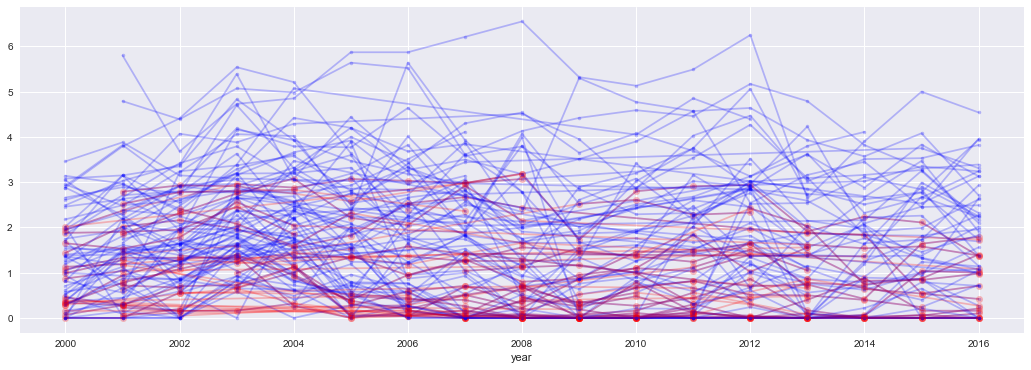

In [229]:
for col in split_cnty_evic_rates:
    if 'flagged' not in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'blue', alpha = .25, marker = '.')
        except:
            continue
    if 'flagged' in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'red', alpha = .25, marker = 'o')
        except:
            continue

#plt.figure(figsize=(18, 6))
plt.show()

To achieve this in Plotly I'll have to make two traces for every county, then I'll have to plot all 190 ish traces. 

pseudo-code:

initialize 190ish variables

for each county assign a scatter graph object to it's two corresponding variables
append the trace to the data to be ploted by plotly. 